In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from torchvision.models import resnet50, resnet18, resnet34

from torchvision import datasets, transforms

/users/cksteven/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://epione.gitlabpages.inria.fr/flhd/federated_learning/FedAvg_FedProx_MNIST_iid_and_noniid.html

In [2]:
# ! curl -o create_MNIST_datasets.py "https://gitlab.inria.fr/epione/flhd/-/raw/master/federated_learning/create_MNIST_datasets.py?inline=false"
# ! curl -o create_synthetic_MNIST_datasets.py "https://gitlab.inria.fr/epione/flhd/-/raw/master/federated_learning/create_synthetic_MNIST_datasets.py?inline=false"


In [18]:
from create_MNIST_datasets import get_MNIST, plot_samples
mnist_iid_train_dls, mnist_iid_test_dls = get_MNIST("iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

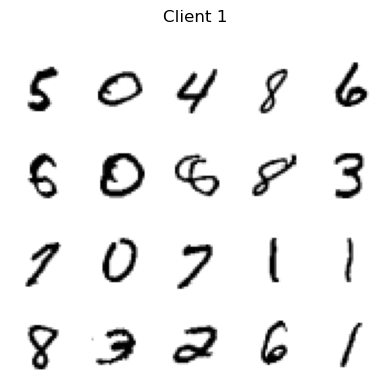

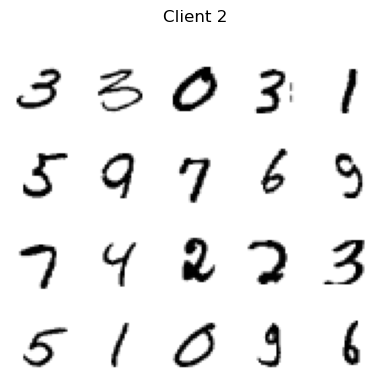

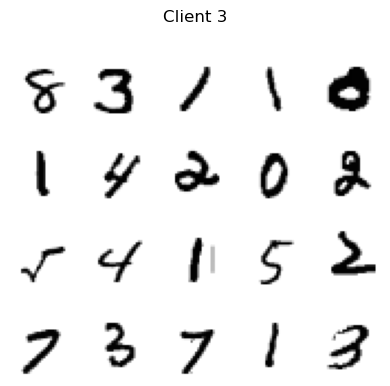

In [19]:
plot_samples(next(iter(mnist_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_iid_train_dls[2])), 0, "Client 3")



In [20]:
mnist_non_iid_train_dls, mnist_non_iid_test_dls = get_MNIST("non_iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

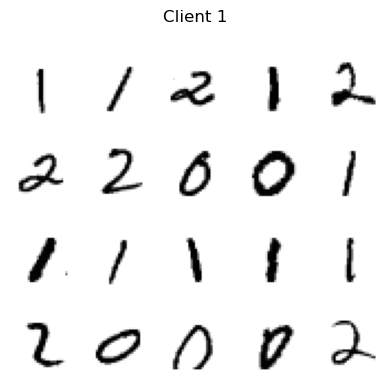

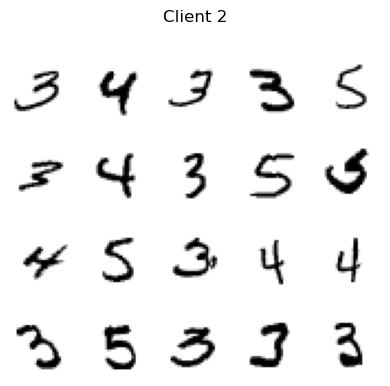

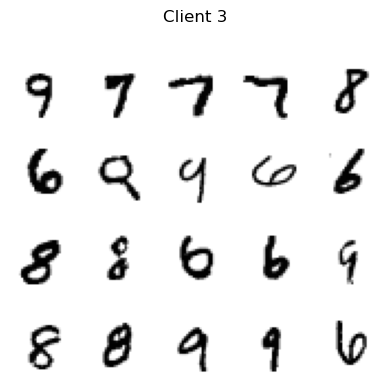

In [21]:
plot_samples(next(iter(mnist_non_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 3")

In [22]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        

In [23]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model

In [24]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = average_models(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

In [82]:
model = resnet18(pretrained=False, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model = model.to(args.device)

/users/cksteven/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/cksteven/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, epochs =2, 
    lr =0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.517580111821492 Server Test Accuracy: 6.0


KeyboardInterrupt: 

In [31]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

NameError: name 'loss_hist_FA_iid' is not defined

In [27]:
n_iter=20

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx(model, mnist_non_iid_train_dls, 
    n_iter, mnist_non_iid_test_dls, epochs=2, lr=0.1, mu=0)

Clients' weights: [0.32666666666666666, 0.2783333333333333, 0.395]
====> i: 0 Loss: 2.5244348124663034 Server Test Accuracy: 9.703718216649252


KeyboardInterrupt: 

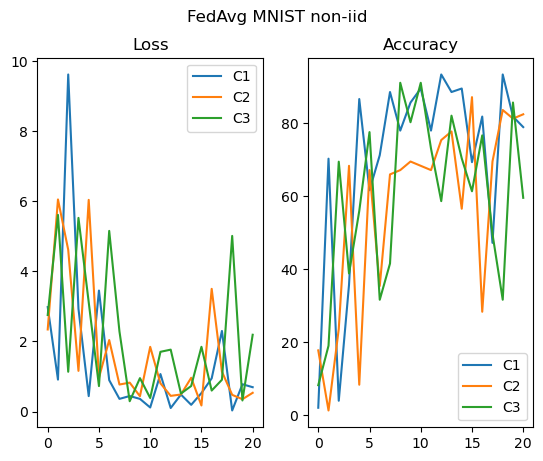

In [20]:
plot_acc_loss("FedAvg MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)


In [28]:
n_iter=20

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx(model, mnist_non_iid_train_dls, 
    n_iter, mnist_non_iid_test_dls, epochs=2, lr=0.1, mu=.3)

Clients' weights: [0.32666666666666666, 0.2783333333333333, 0.395]
====> i: 0 Loss: 2.5307163635889687 Server Test Accuracy: 11.017088993382096
====> i: 1 Loss: 2.102003736893336 Server Test Accuracy: 38.977533960292575
====> i: 2 Loss: 3.142677491903305 Server Test Accuracy: 37.91638366422849
====> i: 3 Loss: 1.5806039575735729 Server Test Accuracy: 56.53568007662835
====> i: 4 Loss: 1.9391318992773692 Server Test Accuracy: 67.05139759665622
====> i: 5 Loss: 1.034628146737814 Server Test Accuracy: 68.84800592128178
====> i: 6 Loss: 0.9804276765386264 Server Test Accuracy: 76.89176245210727
====> i: 7 Loss: 0.9700985991209745 Server Test Accuracy: 74.88327237896203
====> i: 8 Loss: 0.7746427898854017 Server Test Accuracy: 73.82460379658656
====> i: 9 Loss: 1.212544566641251 Server Test Accuracy: 71.16348833159176
====> i: 10 Loss: 0.34406963982929784 Server Test Accuracy: 86.74192354580285
====> i: 11 Loss: 0.11546428903937339 Server Test Accuracy: 93.603578892372
====> i: 12 Loss: 0.0

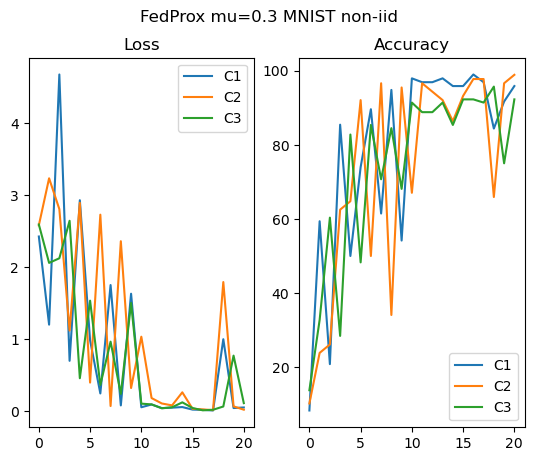

In [32]:
plot_acc_loss("FedProx mu=0.3 MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)


## cifar10

In [2]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    digits_split=list()
    i=0
    for n in range(nb_nodes, 0, -1):
        inc=int((10-i)/n)
        digits_split.append(digits[i:i+inc])
        i+=inc

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        idx=torch.stack([y_ == labels_train_mnist for y_ in digits_split[i]]).sum(0).bool() # get indices for the digits
        data_splitted.append(torch.utils.data.DataLoader(torch.utils.data.TensorDataset(images_train_mnist[idx], labels_train_mnist[idx]), batch_size=batch_size, shuffle=shuffle))

    return data_splitted



def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    # load and shuffle n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)

    data_splitted=list()
    for _ in range(nb_nodes):
        data_splitted.append(torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*(next(dataiter))), batch_size=batch_size, shuffle=shuffle))

    return data_splitted

In [3]:
def  get_CIFAR(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    dataset_loaded_train = datasets.CIFAR10(
            root="./data",
            train=True,
            download=True,
            transform=transforms.ToTensor()
    )
    dataset_loaded_test = datasets.CIFAR10(
            root="./data",
            train=False,
            download=True,
            transform=transforms.ToTensor()
    )

    if type=="iid":
        train=iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test=iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    elif type=="non_iid":
        train=non_iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test=non_iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    else:
        train=[]
        test=[]

    return train, test

In [4]:
def cifar_plot_samples(data, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        # image = 255 - X[idx, channel].view((32,32))
        image = X[idx].permute(1, 2, 0)
        ax.imshow(image)
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

In [80]:
cifar_iid_train_dls, cifar_iid_test_dls = get_CIFAR("iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

Files already downloaded and verified
Files already downloaded and verified


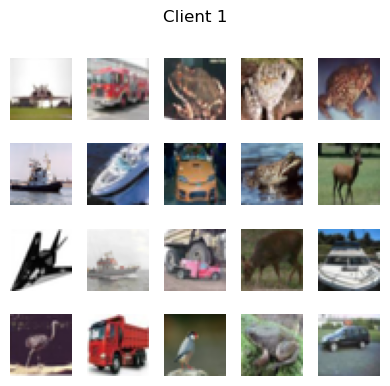

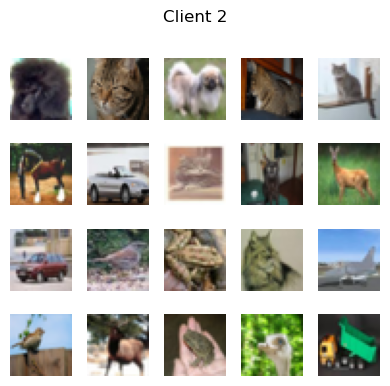

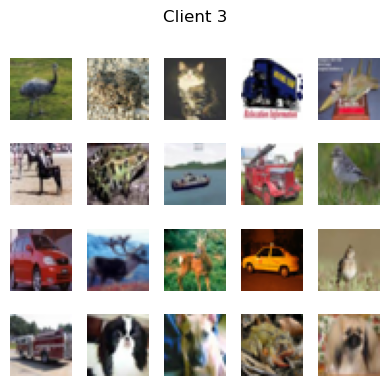

In [81]:
cifar_plot_samples(next(iter(cifar_iid_train_dls[0])), "Client 1")
cifar_plot_samples(next(iter(cifar_iid_train_dls[1])), "Client 2")
cifar_plot_samples(next(iter(cifar_iid_train_dls[2])), "Client 3")

In [11]:
model_cifar = resnet18(pretrained=False, num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model = model.to(args.device)

/users/cksteven/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/cksteven/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [86]:
n_iter=100

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model_cifar, 
    cifar_iid_train_dls, n_iter, cifar_iid_test_dls, epochs=2, 
    lr =0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.5594995816548662 Server Test Accuracy: 11.0
====> i: 1 Loss: 3.1482454140981035 Server Test Accuracy: 9.0
====> i: 2 Loss: 2.575479507446289 Server Test Accuracy: 20.333333333333332
====> i: 3 Loss: 2.1757994890213013 Server Test Accuracy: 30.0
====> i: 4 Loss: 2.304506540298462 Server Test Accuracy: 19.333333333333332
====> i: 5 Loss: 1.5745666027069092 Server Test Accuracy: 29.333333333333332
====> i: 6 Loss: 1.3141600290934243 Server Test Accuracy: 34.33333333333333
====> i: 7 Loss: 1.1698917150497437 Server Test Accuracy: 36.0
====> i: 8 Loss: 1.0573039452234902 Server Test Accuracy: 32.33333333333333
====> i: 9 Loss: 0.8092871308326721 Server Test Accuracy: 34.666666666666664
====> i: 10 Loss: 0.6132544875144958 Server Test Accuracy: 33.666666666666664
====> i: 11 Loss: 0.40132988492647803 Server Test Accuracy: 36.0
====> i: 12 Loss: 0.320420503616333 Server Test Accuracy: 35.33333333

KeyboardInterrupt: 

In [87]:
n_iter=100

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model_cifar, 
    cifar_iid_train_dls, n_iter, cifar_iid_test_dls, epochs=2, 
    lr=0.01, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.5471367835998535 Server Test Accuracy: 13.0
====> i: 1 Loss: 2.1948866049448648 Server Test Accuracy: 15.666666666666666
====> i: 2 Loss: 1.9759069681167603 Server Test Accuracy: 24.33333333333333
====> i: 3 Loss: 1.722312013308207 Server Test Accuracy: 26.33333333333333
====> i: 4 Loss: 1.4156343539555867 Server Test Accuracy: 31.999999999999996
====> i: 5 Loss: 1.1276423533757527 Server Test Accuracy: 25.666666666666664
====> i: 6 Loss: 0.8247101704279581 Server Test Accuracy: 31.33333333333333
====> i: 7 Loss: 0.5022648672262827 Server Test Accuracy: 31.666666666666664
====> i: 8 Loss: 0.3947679003079732 Server Test Accuracy: 31.33333333333333
====> i: 9 Loss: 0.25331013401349384 Server Test Accuracy: 32.666666666666664
====> i: 10 Loss: 0.1541038950284322 Server Test Accuracy: 31.666666666666664
====> i: 11 Loss: 0.11796625951925913 Server Test Accuracy: 33.33333333333333
====> i: 12 L

KeyboardInterrupt: 

In [88]:
n_iter=100

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model_cifar, 
    cifar_iid_train_dls, n_iter, cifar_iid_test_dls, epochs=2, 
    lr=0.001, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.5520874659220376 Server Test Accuracy: 11.666666666666666
====> i: 1 Loss: 2.2877628008524575 Server Test Accuracy: 17.0
====> i: 2 Loss: 2.138384183247884 Server Test Accuracy: 17.0
====> i: 3 Loss: 1.9953007300694783 Server Test Accuracy: 16.666666666666664
====> i: 4 Loss: 1.8775600989659627 Server Test Accuracy: 19.333333333333332
====> i: 5 Loss: 1.768725832303365 Server Test Accuracy: 20.0
====> i: 6 Loss: 1.6267542839050293 Server Test Accuracy: 22.0
====> i: 7 Loss: 1.5299752155939736 Server Test Accuracy: 24.666666666666664
====> i: 8 Loss: 1.420603593190511 Server Test Accuracy: 25.333333333333332
====> i: 9 Loss: 1.3615459203720093 Server Test Accuracy: 23.0
====> i: 10 Loss: 1.2577309608459473 Server Test Accuracy: 26.999999999999996
====> i: 11 Loss: 1.1704727411270142 Server Test Accuracy: 27.666666666666664
====> i: 12 Loss: 1.0901591380437214 Server Test Accuracy: 27.666666

KeyboardInterrupt: 

In [89]:
cifar_iid_train_dls, cifar_iid_test_dls = get_CIFAR("iid",
    n_samples_train =200, n_samples_test=100, n_clients =1, 
    batch_size =100, shuffle =True)

Files already downloaded and verified
Files already downloaded and verified


In [91]:
n_iter=100

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model_cifar, 
    cifar_iid_train_dls, n_iter, cifar_iid_test_dls, epochs=5, 
    lr=0.01, mu=0)

Clients' weights: [1.0]
====> i: 0 Loss: 2.5542569160461426 Server Test Accuracy: 10.0
====> i: 1 Loss: 1.1449722051620483 Server Test Accuracy: 16.0
====> i: 2 Loss: 0.2972378134727478 Server Test Accuracy: 17.0
====> i: 3 Loss: 0.11721307039260864 Server Test Accuracy: 18.0
====> i: 4 Loss: 0.056533221155405045 Server Test Accuracy: 21.0
====> i: 5 Loss: 0.04143087565898895 Server Test Accuracy: 20.0
====> i: 6 Loss: 0.03227093815803528 Server Test Accuracy: 20.0
====> i: 7 Loss: 0.025318972766399384 Server Test Accuracy: 20.0
====> i: 8 Loss: 0.025583740323781967 Server Test Accuracy: 18.0
====> i: 9 Loss: 0.01869562268257141 Server Test Accuracy: 20.0
====> i: 10 Loss: 0.01867513731122017 Server Test Accuracy: 20.0
====> i: 11 Loss: 0.01672840490937233 Server Test Accuracy: 20.0
====> i: 12 Loss: 0.013444610871374607 Server Test Accuracy: 21.0
====> i: 13 Loss: 0.012758586555719376 Server Test Accuracy: 19.0
====> i: 14 Loss: 0.01483955979347229 Server Test Accuracy: 19.0
====> i: 

In [5]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [6]:
transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())

In [7]:
def  get_CIFAR(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    dataset_loaded_train = datasets.CIFAR10(
            root="./data",
            train=True,
            download=True,
            transform=train_transforms
    )
    dataset_loaded_test = datasets.CIFAR10(
            root="./data",
            train=False,
            download=True,
            transform=test_transforms
    )

    if type=="iid":
        train=iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test=iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    elif type=="non_iid":
        train=non_iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test=non_iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    else:
        train=[]
        test=[]

    return train, test

In [8]:
cifar_iid_train_dls, cifar_iid_test_dls = get_CIFAR("iid",
    n_samples_train =200, n_samples_test=100, n_clients =1, 
    batch_size =100, shuffle =True)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
n_iter=100

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx(model_cifar, 
    cifar_iid_train_dls, n_iter, cifar_iid_test_dls, epochs=5, 
    lr=0.01, mu=0)

Clients' weights: [1.0]
====> i: 0 Loss: 2.5745255947113037 Server Test Accuracy: 11.0
====> i: 1 Loss: 1.2654391527175903 Server Test Accuracy: 13.0
====> i: 2 Loss: 0.38720330595970154 Server Test Accuracy: 15.0
====> i: 3 Loss: 0.1187683641910553 Server Test Accuracy: 16.0
====> i: 4 Loss: 0.0713246688246727 Server Test Accuracy: 19.0
====> i: 5 Loss: 0.05143916606903076 Server Test Accuracy: 14.0
====> i: 6 Loss: 0.03587298095226288 Server Test Accuracy: 16.0
====> i: 7 Loss: 0.02824249118566513 Server Test Accuracy: 14.0
====> i: 8 Loss: 0.022190509364008904 Server Test Accuracy: 17.0
====> i: 9 Loss: 0.02056315168738365 Server Test Accuracy: 15.0
====> i: 10 Loss: 0.025480028241872787 Server Test Accuracy: 16.0
====> i: 11 Loss: 0.017370566725730896 Server Test Accuracy: 17.0
====> i: 12 Loss: 0.016931869089603424 Server Test Accuracy: 16.0
====> i: 13 Loss: 0.01735425740480423 Server Test Accuracy: 17.0
====> i: 14 Loss: 0.011274571530520916 Server Test Accuracy: 16.0
====> i: 1

KeyboardInterrupt: 

In [16]:
model_cifar = resnet18(pretrained=False, num_classes=10).to('cuda:1')

In [17]:
# from torchsummary import summary

# summary(model_cifar, input_size=(3,32,32))


In [18]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


In [19]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [20]:
class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

In [21]:
data = GetCIFAR10_TrainData(os.chdir(".."))
trainset = data.download_train_data()
testset = data.download_test_data()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Training the model
# https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cifar.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 40

device = 'cuda:1'

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model_cifar, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model_cifar, device, testloader, test_acc, test_losses)

EPOCHS : 0


Loss=-28880.994140625 Batch_id=97 Accuracy=17.88: 100%|██████████| 98/98 [00:07<00:00, 13.25it/s]   



Test set: Average loss: -39188.7874, Accuracy: 1793/10000 (17.93%)

EPOCHS : 1


Loss=-45510504.0 Batch_id=97 Accuracy=18.06: 100%|██████████| 98/98 [00:07<00:00, 13.89it/s]    



Test set: Average loss: -178688047.1040, Accuracy: 1529/10000 (15.29%)

EPOCHS : 2


Loss=-101561540608.0 Batch_id=97 Accuracy=17.95: 100%|██████████| 98/98 [00:07<00:00, 13.95it/s]



Test set: Average loss: -114213775002.8288, Accuracy: 1641/10000 (16.41%)

EPOCHS : 3


Loss=-239424327647232.0 Batch_id=97 Accuracy=17.25: 100%|██████████| 98/98 [00:06<00:00, 14.04it/s]



Test set: Average loss: -268764343120691.1875, Accuracy: 1596/10000 (15.96%)

EPOCHS : 4


Loss=-5.766341315432284e+17 Batch_id=97 Accuracy=12.88: 100%|██████████| 98/98 [00:07<00:00, 13.94it/s] 



Test set: Average loss: -637338304522329728.0000, Accuracy: 1872/10000 (18.72%)

EPOCHS : 5


Loss=-1.3919333070684218e+21 Batch_id=97 Accuracy=11.06: 100%|██████████| 98/98 [00:07<00:00, 13.93it/s]



Test set: Average loss: -1527607464790791553024.0000, Accuracy: 1283/10000 (12.83%)

EPOCHS : 6


Loss=nan Batch_id=97 Accuracy=10.07: 100%|██████████| 98/98 [00:07<00:00, 13.92it/s]                    



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCHS : 7


Loss=nan Batch_id=11 Accuracy=9.67:  12%|█▏        | 12/98 [00:01<00:08, 10.64it/s]


KeyboardInterrupt: 

In [24]:
https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

SyntaxError: invalid syntax (691589529.py, line 1)